In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
from datetime import datetime
date_format = "%Y-%m-%d"
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
from pandas import DataFrame
from prophet import Prophet
from prophet.diagnostics import cross_validation
from pandas import read_csv

In [189]:
data = read_csv('forecasting_features.csv', header=0)
data.columns

Index(['DATE', 'T2M_MAX', 'T2M_MIN', 'T2M', 'PRECTOTCORR', 'TS_MAX', 'TS_MIN',
       'TS', 'RH2M', 'T2MDEW', 'PS', 'WS2M', 'ALLSKY_SFC_SW_DWN'],
      dtype='object')

In [190]:
data.tail()

,DATE,T2M_MAX,T2M_MIN,T2M,PRECTOTCORR,TS_MAX,TS_MIN,TS,RH2M,T2MDEW,PS,WS2M,ALLSKY_SFC_SW_DWN
7888,2021-08-06,28.62,22.55,25.41,10.55,29.44,22.19,25.40,89.94,23.58,96.63,2.48,5.90
7889,2021-08-07,28.55,23.02,25.62,0.00,29.20,22.66,25.59,91.12,24.01,96.69,2.66,6.52
7890,2021-08-08,28.78,23.86,25.83,5.27,29.08,23.50,25.73,92.62,24.51,96.65,2.27,6.58
7891,2021-08-09,29.23,23.83,26.23,5.27,29.77,23.51,26.17,92.06,24.80,96.53,2.20,6.51
7892,2021-08-10,28.46,24.39,26.12,5.27,28.73,24.02,25.98,92.81,24.83,96.42,1.70,5.67


In [191]:
data['DATE']= pd.to_datetime(data['DATE'])

In [192]:
data = data.drop(['T2M_MIN', 'T2M','PRECTOTCORR', 'TS_MAX', 'TS_MIN', 'RH2M', 'T2MDEW','PS','TS', 'WS2M', 'ALLSKY_SFC_SW_DWN' ], axis=1)
data

,DATE,T2M_MAX
0,2000-01-01,29.83
1,2000-01-02,29.51
2,2000-01-03,30.33
3,2000-01-04,31.09
4,2000-01-05,32.33
...,...,...
7888,2021-08-06,28.62
7889,2021-08-07,28.55
7890,2021-08-08,28.78
7891,2021-08-09,29.23


<AxesSubplot:xlabel='DATE'>

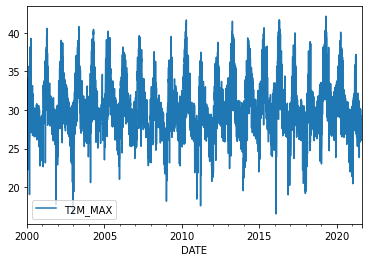

In [193]:
data.plot('DATE', 'T2M_MAX')

In [194]:
#set date as index
data.set_index('DATE', inplace=True)
print(data)
data.columns


            T2M_MAX
DATE               
2000-01-01    29.83
2000-01-02    29.51
2000-01-03    30.33
2000-01-04    31.09
2000-01-05    32.33
...             ...
2021-08-06    28.62
2021-08-07    28.55
2021-08-08    28.78
2021-08-09    29.23
2021-08-10    28.46

[7893 rows x 1 columns]


Index(['T2M_MAX'], dtype='object')

In [163]:
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2020-07-01')
data = data[start_date: end_date]

In [195]:
start_date = pd.to_datetime('2020-07-02')
end_date = pd.to_datetime('2020-10-29')
data_test = data[start_date: end_date]
data_test

,T2M_MAX
DATE,
2020-07-02,26.98
2020-07-03,26.82
2020-07-04,28.60
2020-07-05,29.77
2020-07-06,31.61
...,...
2020-10-25,25.26
2020-10-26,24.37
2020-10-27,27.39


In [164]:
#no differencing

data['ds'] = data.index
data.columns

# # data.dropna(subset=['y'], inplace=True)
# # df_train = data[['ds', 'y']]
# # df_train



/tmp/ipykernel_31300/3001189820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ds'] = data.index


Index(['T2M_MAX', 'ds'], dtype='object')

<AxesSubplot:xlabel='ds'>

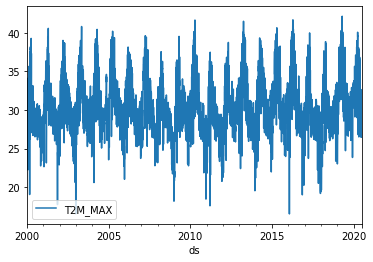

In [165]:
data.plot('ds', 'T2M_MAX')

In [166]:
data.shape

(7488, 2)

In [167]:
data.rename(columns={'ds':'ds','T2M_MAX':'y'},inplace=True)
data.shape
data.head()

/home/kudomcho/.local/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,y,ds
DATE,,
2000-01-01,29.83,2000-01-01
2000-01-02,29.51,2000-01-02
2000-01-03,30.33,2000-01-03
2000-01-04,31.09,2000-01-04
2000-01-05,32.33,2000-01-05


In [168]:
data.columns

Index(['y', 'ds'], dtype='object')

In [169]:
df_train = data[['ds', 'y']]
df_train


,ds,y
DATE,,
2000-01-01,2000-01-01,29.83
2000-01-02,2000-01-02,29.51
2000-01-03,2000-01-03,30.33
2000-01-04,2000-01-04,31.09
2000-01-05,2000-01-05,32.33
...,...,...
2020-06-27,2020-06-27,29.36
2020-06-28,2020-06-28,28.55
2020-06-29,2020-06-29,30.44


In [15]:
#differencing
#set date as index
data.set_index('DATE', inplace=True)
print(data)
data_diff = data

data_diff = data.diff(periods=1)
data_diff.plot()
data_diff['ds'] = data_diff.index
data_diff.columns
data_diff.rename(columns={'ds':'ds','MAXIMUM TEMPERATURE':'y'},inplace=True)
data.shape
data_diff.head()
data_diff.dropna(subset=['y'], inplace=True)
df_train = data_diff[['ds', 'y']]
df_train

KeyError: "None of ['DATE'] are in the columns"

In [170]:
m = Prophet()
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -31.9528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         17546    0.00872958       440.637           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17565.1    0.00275074       273.961           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17582.3    0.00539336       220.217           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       17586.7   2.53402e-05       90.6275   2.104e-07       0.001      518  LS failed, Hessian reset 
     399         17587    0.00153912       143.248      0.1679           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     481       17587.8   2.12927e-05    

In [175]:
future = m.make_future_dataframe(periods=120)
future[7488:7608]

,ds
7488,2020-07-02
7489,2020-07-03
7490,2020-07-04
7491,2020-07-05
7492,2020-07-06
...,...
7603,2020-10-25
7604,2020-10-26
7605,2020-10-27
7606,2020-10-28


In [176]:
df_train.shape

(7488, 2)

In [209]:
df_train

,ds,y
DATE,,
2000-01-01,2000-01-01,29.83
2000-01-02,2000-01-02,29.51
2000-01-03,2000-01-03,30.33
2000-01-04,2000-01-04,31.09
2000-01-05,2000-01-05,32.33
...,...,...
2020-06-27,2020-06-27,29.36
2020-06-28,2020-06-28,28.55
2020-06-29,2020-06-29,30.44


In [210]:
future

,ds
0,2000-01-01
1,2000-01-02
2,2000-01-03
3,2000-01-04
4,2000-01-05
...,...
7603,2020-10-25
7604,2020-10-26
7605,2020-10-27
7606,2020-10-28


In [177]:
forecast = m.predict(future)



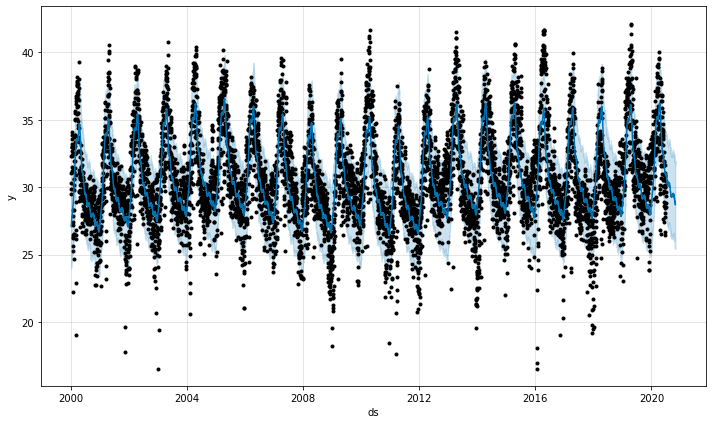

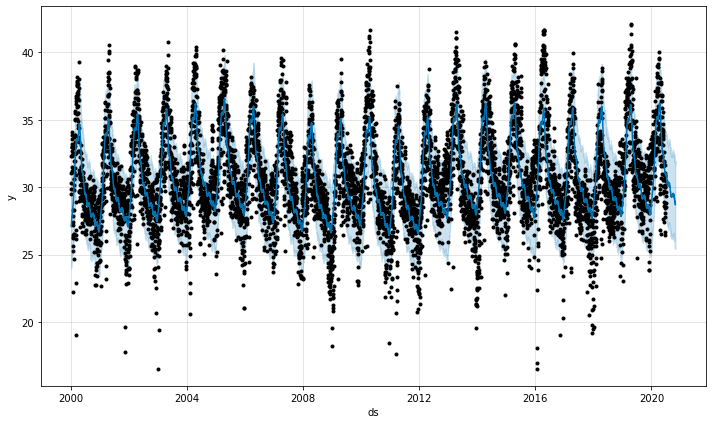

In [178]:
m.plot(forecast)

In [179]:
forecast[7488:7608]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7488,2020-07-02,31.181831,27.849575,34.041127,31.181831,31.181831,-0.207500,-0.207500,-0.207500,0.013540,0.013540,0.013540,-0.221039,-0.221039,-0.221039,0.0,0.0,0.0,30.974332
7489,2020-07-03,31.182185,27.732534,33.898069,31.182185,31.182185,-0.282190,-0.282190,-0.282190,-0.044874,-0.044874,-0.044874,-0.237316,-0.237316,-0.237316,0.0,0.0,0.0,30.899995
7490,2020-07-04,31.182540,27.912721,33.915645,31.182540,31.182540,-0.252653,-0.252653,-0.252653,0.004233,0.004233,0.004233,-0.256886,-0.256886,-0.256886,0.0,0.0,0.0,30.929887
7491,2020-07-05,31.182894,28.078655,34.047856,31.182894,31.182894,-0.218384,-0.218384,-0.218384,0.061669,0.061669,0.061669,-0.280053,-0.280053,-0.280053,0.0,0.0,0.0,30.964510
7492,2020-07-06,31.183248,27.945640,33.795078,31.183248,31.183248,-0.303368,-0.303368,-0.303368,0.003632,0.003632,0.003632,-0.307000,-0.307000,-0.307000,0.0,0.0,0.0,30.879880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,2020-10-25,31.222554,25.937483,32.027063,31.191858,31.243928,-2.322401,-2.322401,-2.322401,0.061669,0.061669,0.061669,-2.384070,-2.384070,-2.384070,0.0,0.0,0.0,28.900153
7604,2020-10-26,31.222908,25.847534,31.668852,31.191532,31.245173,-2.419303,-2.419303,-2.419303,0.003632,0.003632,0.003632,-2.422935,-2.422935,-2.422935,0.0,0.0,0.0,28.803605
7605,2020-10-27,31.223262,25.587692,31.962233,31.191206,31.246026,-2.503414,-2.503414,-2.503414,-0.043811,-0.043811,-0.043811,-2.459603,-2.459603,-2.459603,0.0,0.0,0.0,28.719848
7606,2020-10-28,31.223616,25.401796,31.783050,31.191031,31.246649,-2.488019,-2.488019,-2.488019,0.005612,0.005612,0.005612,-2.493631,-2.493631,-2.493631,0.0,0.0,0.0,28.735597


In [180]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

[[30.97433179]
 [30.89999515]
 [30.92988662]
 [30.96450977]
 [30.87987995]
 [30.80201327]
 [30.8172578 ]
 [30.7874566 ]
 [30.68808455]
 [30.69343835]
 [30.70485687]
 [30.59914867]
 [30.50305903]
 [30.50358127]
 [30.46310233]
 [30.35752505]
 [30.36144695]
 [30.37637291]
 [30.27913877]
 [30.19637825]
 [30.21483791]
 [30.19653006]
 [30.11686567]
 [30.14984694]
 [30.19629644]
 [30.13229925]
 [30.08369018]
 [30.13639014]
 [30.15158083]
 [30.10385952]
 [30.16645271]
 [30.2394651 ]
 [30.19833997]
 [30.16836224]
 [30.23500822]
 [30.25913075]
 [30.2151212 ]
 [30.27612715]
 [30.34230201]
 [30.28926271]
 [30.24258698]
 [30.28815425]
 [30.28731938]
 [30.21506086]
 [30.2451828 ]
 [30.27854743]
 [30.19151466]
 [30.11042084]
 [30.12190109]
 [30.08804501]
 [29.98452785]
 [29.98579688]
 [29.99329003]
 [29.88386375]
 [29.78426224]
 [29.78143302]
 [29.7376783 ]
 [29.62878458]
 [29.62920997]
 [29.64030637]
 [29.53875301]
 [29.45103361]
 [29.46376152]
 [29.43884208]
 [29.3516144 ]
 [29.37605142]
 [29.41299

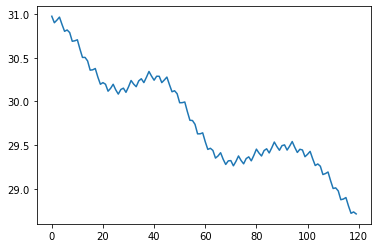

In [181]:
forecast_test = forecast[7488:7608][['yhat']]
print(forecast_test.values)
pyplot.plot(forecast_test.values, label = 'predicted values')

In [182]:
forecast[7488:7608][['ds', 'yhat', 'yhat_upper', 'yhat_lower']]

,ds,yhat,yhat_upper,yhat_lower
7488,2020-07-02,30.974332,34.041127,27.849575
7489,2020-07-03,30.899995,33.898069,27.732534
7490,2020-07-04,30.929887,33.915645,27.912721
7491,2020-07-05,30.964510,34.047856,28.078655
7492,2020-07-06,30.879880,33.795078,27.945640
...,...,...,...,...
7603,2020-10-25,28.900153,32.027063,25.937483
7604,2020-10-26,28.803605,31.668852,25.847534
7605,2020-10-27,28.719848,31.962233,25.587692
7606,2020-10-28,28.735597,31.783050,25.401796


In [196]:
data_test_1=data_test['T2M_MAX'].values
data_test_1[0:121]
data_test

,T2M_MAX
DATE,
2020-07-02,26.98
2020-07-03,26.82
2020-07-04,28.60
2020-07-05,29.77
2020-07-06,31.61
...,...
2020-10-25,25.26
2020-10-26,24.37
2020-10-27,27.39


[26.98 26.82 28.6  29.77 31.61 29.35 31.95 30.11 29.73 29.26 29.37 28.16
 27.98 30.01 28.58 30.35 30.54 28.59 29.34 28.1  30.08 31.48 31.18 30.08
 30.64 29.07 29.46 30.1  30.71 29.69 27.19 27.27 30.63 29.27 28.15 28.62
 29.89 28.9  29.65 28.32 29.08 29.38 27.8  27.79 26.87 27.85 29.75 30.3
 29.48 26.75 25.55 28.98 28.76 29.82 30.49 31.06 29.95 30.71 29.98 30.47
 30.8  29.26 30.94 29.97 30.4  29.44 29.42 29.18 27.79 29.7  28.73 30.11
 28.72 26.68 28.76 27.42 30.26 31.01 28.51 27.33 27.08 28.5  27.05 28.98
 30.02 29.54 28.4  29.01 28.88 28.77 29.23 27.39 28.56 27.84 28.44 28.99
 30.18 28.31 23.31 25.71 23.95 27.33 23.37 25.64 28.49 28.58 28.4  25.38
 24.59 23.2  23.75 25.23 26.24 25.69 26.04 25.26 24.37 27.39 27.71 25.41]


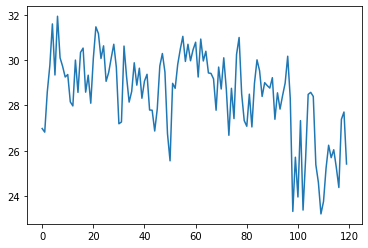

In [197]:
data_test_1=data_test['T2M_MAX'].values

print(data_test_1)
pyplot.plot(data_test_1, label = 'actual values')

In [207]:

diff_list = []
diff_accepted =[]
diff_rejected = []
count_rejected = 0
count_accepted = 0
for idx, yhat in enumerate(forecast_test.values):
    
    diff = yhat-data_test_1[idx]
   
    if diff>3 or diff<-3:
        diff_rejected.append(diff)
        count_rejected +=1
        
    else:
        diff_accepted.append(diff)
        count_accepted +=1
            
print(count_rejected)
print(count_accepted)

19
101


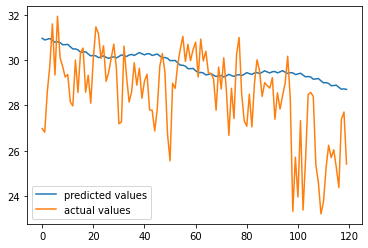

In [208]:
pyplot.plot(forecast_test.values, label = 'predicted values')
pyplot.plot(data_test_1, label = 'actual values')
pyplot.legend()

In [318]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [322]:
from ipywidgets import FloatProgress

In [198]:
df_cv = cross_validation(m, initial='7000 days', period='60 days', horizon = '120 days')


INFO:prophet:Making 7 forecasts with cutoffs between 2019-03-09 00:00:00 and 2020-03-03 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

Initial log joint probability = -53.4866
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16409.3     0.0106138       567.164           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       16432.8     0.0171415       1049.48           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       16441.7     0.0021094       751.061           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       16444.6    0.00103266       233.804           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421         16446   0.000187138       363.647   9.196e-07       0.001      548  LS failed, Hessian reset 
     499       16448.3   0.000401866    

Initial log joint probability = -28.2959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17061.7     0.0097013       587.606           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17077.2     0.0107435       1169.03      0.4069           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17092.8     0.0136086        475.07      0.3432           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       17093.3   3.09415e-05       93.5985   1.644e-07       0.001      413  LS failed, Hessian reset 
     399       17096.2   0.000441316       380.424      0.4494      0.8651      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     440       17096.9   6.02949e-05    

In [28]:
df_cv = cross_validation(m, initial='1200 days', period='7 days', horizon = '15 days')


INFO:prophet:Making 9 forecasts with cutoffs between 2021-04-21 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

Initial log joint probability = -7.35893
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2962.38    0.00205257       75.8373      0.2166           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       2962.84   0.000576274       225.169   6.513e-06       0.001      234  LS failed, Hessian reset 
     183        2962.9   2.31699e-07       55.9007           1           1      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.98326
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2977.57   0.000641743       158.318      0.5833      0.5833      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       2979.39   0.000167101       131.205   1.449e-06       0.0

In [199]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,12 days,8.413614,2.900623,2.485971,0.074491,0.071108,0.077086,0.619048
1,13 days,9.166245,3.027581,2.622090,0.078361,0.074576,0.081255,0.595238
2,14 days,9.366039,3.060399,2.626143,0.077623,0.074576,0.081010,0.595238
3,15 days,9.272131,3.045017,2.625004,0.077708,0.074576,0.081110,0.607143
4,16 days,9.146735,3.024357,2.603665,0.077146,0.074576,0.080493,0.619048
...,...,...,...,...,...,...,...,...
104,116 days,10.441118,3.231272,2.528626,0.081838,0.061769,0.082553,0.654762
105,117 days,8.957880,2.992972,2.355859,0.076979,0.058843,0.077429,0.690476
106,118 days,8.166101,2.857639,2.198419,0.071864,0.055628,0.072376,0.726190
107,119 days,7.600681,2.756933,2.091464,0.068245,0.049546,0.068765,0.761905


In [76]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,3.344853,1.828894,1.475169,0.047549,0.051966,0.047744,0.820513
1,3 days,3.455017,1.858768,1.530168,0.049099,0.057341,0.049930,0.888889
2,4 days,6.433938,2.536521,2.248292,0.073227,0.072467,0.073819,0.735043
3,5 days,5.653093,2.377623,2.117368,0.068904,0.069064,0.069483,0.743590
4,6 days,4.007767,2.001941,1.676845,0.054384,0.046143,0.054861,0.777778
5,7 days,2.684758,1.638523,1.311158,0.043105,0.039244,0.043063,0.931624
6,8 days,4.021582,2.005388,1.627575,0.053329,0.039372,0.053314,0.769231
7,9 days,3.620131,1.902664,1.500064,0.048996,0.061050,0.049274,0.820513
8,10 days,3.987353,1.996836,1.625541,0.052445,0.062086,0.053419,0.888889
9,11 days,6.520642,2.553555,2.220541,0.073358,0.066487,0.073977,0.811966


In [31]:
import json
from prophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model